##다음에 볼 영화 예측하기

개발 환경
<br/>데이터 정보

데이터 전처리
<br/>Session ID
<br/>Session Length
<br/>Session Time
<br/>데이터 정제
<br/>데이터 분리

데이터 파이프라인
<br/>Session Dataset
<br/>Session-Parallel Mini-Batch

모델 구성

모델 학습
<br/>Hyper Parameter Tuning
<br/>First Model
<br/>Second Model
<br/>Third Model
<br/>Fourth Model

모델 평가
<br/>결론
<br/>참고문헌

# 개발 환경

In [ ]:
import os
import pickle
import copy
import datetime as dt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['pandas=', 'numpy=', 'pickle', 'pathlib=', 'tensorflow=', 'keras=', 'tqdm=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

cloudpickle==1.3.0      keras==2.8.0      numpy==1.21.6     
pandas==1.3.5      pathlib==1.0.1      pickleshare==0.7.5     
sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220527125636      tqdm==4.64.0     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보

[MovieLens 1M Dataset](https://grouplens.org/datasets/movielens/)

GroupLens Research가 [MovieLens](https://movielens.org)에서  영화 3,952편에 대한 6,040명의 사용자의 평점 1,000,209개를 수집한 데이터셋이다.
<br/>논문 [The MovieLens Datasets: History and Contex](https://grouplens.org/blog/movielens-datasets-context-and-history/)에서는 MovieLens 데이터셋의 역사에 대해서 이야기한다.

In [ ]:
readme_path = '/content/drive/MyDrive/lms/recommender_system/ml-1m/README'
f = open(readme_path, 'r')
line_num = 0
while True:
    line = f.readline()
    line_num += 1
    if 76 <= line_num <= 77 or 84 <= line_num <= 87:
      print(line)
    elif not line: break

f.close()

RATINGS FILE DESCRIPTION


- UserIDs range between 1 and 6040 

- MovieIDs range between 1 and 3952

- Ratings are made on a 5-star scale (whole-star ratings only)

- Timestamp is represented in seconds since the epoch as returned by time(2)



Session-Based Recommendation 데이터

사용자에 대한 정보(성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역)를 알 수 없다.
<br/>아이템에 대한 정보(사진, 설명, 가격)를 알 수 없다.

Sequential Recommendation 데이터

사용자에 대한 정보를 알 수 있다.

In [ ]:
rating_file_path = '/content/drive/MyDrive/lms/recommender_system/ml-1m/ratings.dat'

In [ ]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserID', 'ItemID', 'Rating', 'Time']
    return data

In [ ]:
ratings = load_data(rating_file_path, None)
ratings['Time'] = ratings['Time'].map(lambda x: pd.Timestamp(x, unit='s'))  
ratings.sort_values(by=['UserID', 'Time'], inplace=True) 
ratings = ratings.reset_index()
ratings = ratings[['UserID', 'ItemID', 'Rating', 'Time']]

In [ ]:
ratings

,UserID,ItemID,Rating,Time
0,1,3186,4,2000-12-31 22:00:19
1,1,1270,5,2000-12-31 22:00:55
2,1,1721,4,2000-12-31 22:00:55
3,1,1022,5,2000-12-31 22:00:55
4,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29
1000205,6040,1921,4,2001-08-10 14:41:04
1000206,6040,1784,3,2001-08-10 14:41:04
1000207,6040,161,3,2001-08-10 14:41:26


데이터를 UserId와 Time 순서로 정렬한다.

Timestamp(year-month-day hour:minute:second) 형식으로 Time을 변형한다.
<br/>시간 단위는 UTC time을 기준으로 한다.

#데이터 전처리

##Session ID

In [ ]:
session_index = 1
session_index_list = []

for i in range(len(ratings) - 1):
  if (ratings['Time'][i + 1] - ratings['Time'][i]) > pd.Timedelta("0 days 00:01:00"):
    session_index += 1
  session_index_list.append(session_index)
session_index_list.append(session_index)

In [ ]:
ratings['SessionID'] = session_index_list
ratings = ratings[['SessionID', 'UserID', 'ItemID', 'Rating', 'Time']]

In [ ]:
ratings

,SessionID,UserID,ItemID,Rating,Time
0,1,1,3186,4,2000-12-31 22:00:19
1,1,1,1270,5,2000-12-31 22:00:55
2,1,1,1721,4,2000-12-31 22:00:55
3,1,1,1022,5,2000-12-31 22:00:55
4,2,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...,...
1000204,112224,6040,2917,4,2001-08-10 14:40:29
1000205,112224,6040,1921,4,2001-08-10 14:41:04
1000206,112224,6040,1784,3,2001-08-10 14:41:04
1000207,112225,6040,161,3,2001-08-10 14:41:26


UserID의 Time 1분을 기준으로 하여 Session ID를 생성한다.
<br/>사용자의 평점 클릭 시간 1분 내에서 동일한 SessionID로 정의한다.
<br/>세션은 브라우저가 종료되기 전까지 클라이언트의 요청을 유지하게 해주는 기술로 세션의 내용은 서버에 저장된다. 

In [ ]:
ratings['SessionID'].nunique(), ratings['ItemID'].nunique()

(112225, 3706)

세션의 숫자가 112225개, 아이템 숫자는 3706개다.

##Session Length

In [ ]:
session_length = ratings.groupby(['SessionID']).size()

session_length는 해당 세션의 사용자가 그 세션 동안 몇 번의 행동을 취했는지를 의미한다.
<br/>SessionID는 브라우저에서 웹서버로 접속할 때 항상 포함하는 사용자의 구분자이다.

평균 길이 :  8.912532858097572
최소 길이 :  1
최대 길이 :  665
중간 길이 :  3.0
표준 편차 :  19.397081459922788



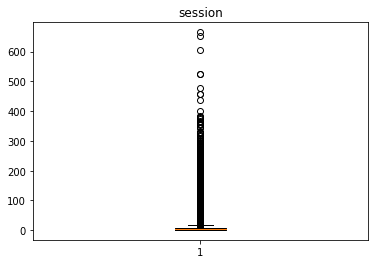

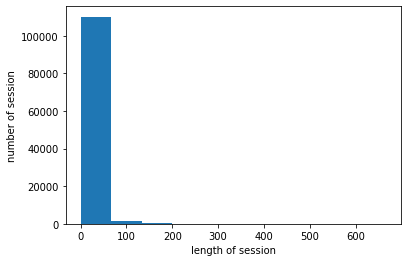

In [ ]:
print('평균 길이 : ', session_length.mean())
print('최소 길이 : ', session_length.min())
print('최대 길이 : ', session_length.max())
print('중간 길이 : ', session_length.median())
print('표준 편차 : ', session_length.std())

print()
plt.boxplot(session_length)
plt.title('session')
plt.show()

print()
plt.hist(session_length)
plt.xlabel('length of session')
plt.ylabel('number of session')
plt.show()

각 세션의 길이는 평균 8~9이다.

In [ ]:
session_length.quantile(0.999)

215.0

99.9% 세션은 길이가 215 이하이다.

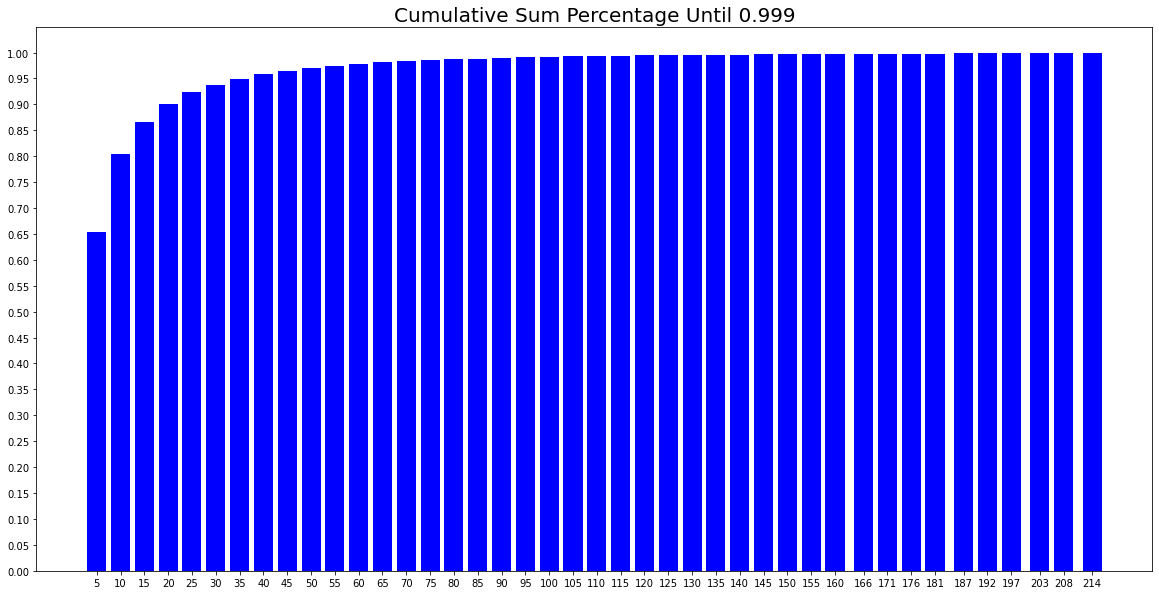

In [ ]:
length_count = session_length.groupby(session_length).size()
length_percent_cumlative_sum = length_count.cumsum() / length_count.sum()
length_percent_cumlative_sum_999 = length_percent_cumlative_sum[length_percent_cumlative_sum < 0.999]


length = len(length_percent_cumlative_sum_999.index)
sum_list = []
index_list = []

for i in range(0, length, 5):
  sum_list.append(list(length_percent_cumlative_sum_999)[i+4:i+5])

for i in range(0, length, 5):
  index_list.append(length_percent_cumlative_sum_999.index[i+4:i+5][0])

sum_list = sum(sum_list, [])


plt.figure(figsize=(20, 10))
plt.bar(x=index_list,
        height=sum_list, color='blue', width=4)


plt.xticks(index_list)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumulative Sum Percentage Until 0.999', size=20)
plt.show()

세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한다.

##Session Time

In [ ]:
oldest, latest = ratings['Time'].min(), ratings['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


3년 간의 영화 평점 데이터가 있다.
<br/>그 중에 최근 1년 데이터를 사용한다.

In [ ]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.
<br/>날짜의 차이를 계산할 때 datetime의 timedelta 객체를 사용한다.

In [ ]:
year_ago = latest - dt.timedelta(365)     
one_year_ratings = ratings[ratings['Time'] > year_ago]  

In [ ]:
one_year_ratings

,SessionID,UserID,ItemID,Rating,Time
5333,527,36,1387,5,2002-03-12 03:46:59
5334,527,36,1201,4,2002-03-12 03:46:59
5335,528,36,1291,5,2002-03-12 03:47:16
5336,528,36,2167,5,2002-03-12 03:48:25
5337,528,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...,...
992789,111682,5996,3835,3,2002-04-29 20:46:24
992790,111683,5996,2422,3,2002-04-29 20:47:05
992791,111684,5996,168,3,2002-09-03 13:12:26
992792,111685,5996,339,4,2002-10-07 13:24:39


최종 날짜로부터 365일 이전 날짜 2002-02-28를 구한다.
<br/>2002-02-28부터 2003-02-28까지 1년 간의 데이터만 모은다.

##데이터 정제

In [ ]:
def cleanse_short_session(data: pd.DataFrame, shortest_session):
    session_len = data.groupby('SessionID').size()
    session_use = session_len[session_len >= shortest_session].index
    data = data[data['SessionID'].isin(session_use)]
    return data

In [ ]:
def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemID').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemID'].isin(item_use)]
    return data

In [ ]:
def cleanse_low_rating(data: pd.DataFrame, lowest_rating):
    idx_rating = data[data['Rating'] < lowest_rating].index
    data = data.drop(idx_rating)
    return data

In [ ]:
def cleanse_recursive(data: pd.DataFrame, shortest_session, least_click, lowest_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest_session)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    
    data = cleanse_low_rating(data, lowest_rating)
    return data

In [ ]:
preprocess_ratings = cleanse_recursive(one_year_ratings, shortest_session=2, least_click=5, lowest_rating=3)

추천 시스템의 목적은 사용자가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제외한다.
<br/>5번 이하의 클릭이 됐거나 3점 이하의 평점을 받은 item은 제외한다.

In [ ]:
preprocess_ratings

,SessionID,UserID,ItemID,Rating,Time
5333,527,36,1387,5,2002-03-12 03:46:59
5334,527,36,1201,4,2002-03-12 03:46:59
5335,528,36,1291,5,2002-03-12 03:47:16
5336,528,36,2167,5,2002-03-12 03:48:25
5337,528,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...,...
992779,111676,5996,2616,3,2002-04-29 20:16:15
992780,111677,5996,3707,5,2002-04-29 20:16:15
992781,111677,5996,781,5,2002-04-29 20:18:44
992792,111685,5996,339,4,2002-10-07 13:24:39


In [ ]:
preprocess_ratings.isnull().sum()

SessionID    0
UserID       0
ItemID       0
Rating       0
Time         0
dtype: int64

데이터에 결측치가 존재하지 않는다.

##데이터 분리

In [ ]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionID')['Time'].max()
   
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionID'].isin(session_in_train)]
    after_date = data[data['SessionID'].isin(session_in_test)]
    after_date = after_date[after_date['ItemID'].isin(before_date['ItemID'])]
    return before_date, after_date

In [ ]:
train, test = split_by_date(preprocess_ratings, n_days=2)
train, val = split_by_date(train, n_days=2)

split_by_date는 훈련 데이터(2002-02-28 ~ 2003-02-24), 평가 데이터(2003-02-24 ~ 26), 시험 데이터(2003-02-26 ~ 28)로 분리한다.

In [ ]:
test.head()

,SessionID,UserID,ItemID,Rating,Time
59567,6789,403,1097,4,2002-03-27 00:54:52
59568,6789,403,1036,4,2003-02-27 23:31:15
63596,7646,424,2324,4,2003-02-26 15:23:29
63597,7646,424,2581,3,2003-02-27 12:31:39
562872,67318,3462,3893,4,2003-02-27 13:14:14


In [ ]:
test = test.drop(index=[59567, 609455, 825872, 984291], axis=0)

시험 데이터에서 Time이 2003-02-26 ~ 28가 아닌 결측치를 제거한다.

In [ ]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionID"].nunique()}\n'
          f'\t Items: {data["ItemID"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [ ]:
stats_info(train, 'Train')
stats_info(val, 'Validation')
stats_info(test, 'Test')

* Train Set Stats Info
	 Events: 10911
	 Sessions: 2509
	 Items: 1213
	 First Time : 2002-02-28 19:14:41
	 Last Time : 2003-02-24 06:02:24

* Validation Set Stats Info
	 Events: 114
	 Sessions: 43
	 Items: 113
	 First Time : 2003-02-24 17:02:07
	 Last Time : 2003-02-26 16:18:03

* Test Set Stats Info
	 Events: 43
	 Sessions: 17
	 Items: 42
	 First Time : 2003-02-26 15:23:29
	 Last Time : 2003-02-28 17:49:08



In [ ]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemID'].unique())}

In [ ]:
def indexing(df, id2idx):
    df['item_idx'] = df['ItemID'].map(lambda x: id2idx.get(x, -1))  
    return df

훈련 데이터에 없는 아이템이 평가 및 시험 기간에 생길 수 있으므로 훈련 데이터를 기준으로 인덱싱한다.
<br/>id2idx에 없는 아이템은 모르는 값을 -1로 처리 한다.

In [ ]:
train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [ ]:
os.environ['home'] = '/content'
save_path =  Path(os.getenv('home') + '/drive/MyDrive/lms/recommender_system/preprocessed_data')
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'val.pkl')
test.to_pickle(save_path / 'test.pkl')

데이터를 저장한다.

#데이터 파이프라인

##Session Dataset

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionID'].nunique())  

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs.
        """
        
        offsets = np.zeros(self.df['SessionID'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionID').size().cumsum()
        return offsets

데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [ ]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,SessionID,UserID,ItemID,Rating,Time,item_idx
5333,527,36,1387,5,2002-03-12 03:46:59,0
5334,527,36,1201,4,2002-03-12 03:46:59,1
5335,528,36,1291,5,2002-03-12 03:47:16,2
5336,528,36,2167,5,2002-03-12 03:48:25,3
5337,528,36,2951,4,2002-03-12 03:48:25,4
5338,528,36,2115,5,2002-03-12 03:48:25,5
5339,528,36,1912,5,2002-03-12 03:48:44,6
5340,528,36,2662,3,2002-03-12 03:48:44,7
5341,528,36,2985,4,2002-03-12 03:49:01,8
5343,529,36,198,5,2002-03-12 03:49:48,9


훈련 데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 확인한다.

In [ ]:
train_dataset.click_offsets

array([    0,     2,     9, ..., 10907, 10909, 10911], dtype=int32)

click_offsets 변수는 각 세션이 시작된 인덱스를 담는다.

In [ ]:
train_dataset.session_idx

array([   0,    1,    2, ..., 2506, 2507, 2508])

session_idx 변수는 각 세션을 인덱싱한 np.array이다.

##Session-Parallel Mini-Batch

Session-Parallel Mini-Batch의 개념에 따라 학습 속도의 저하가 최소화될 수 있도록 구성한다.

In [ ]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # 세션의 최소 길이
            for i in range(min_len):
                # 입력 데이터와 타겟 데이터를 정의한다.
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져온다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장한다.
        
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]      # data 상에서 session이 시작된 위치를 가져온다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져온다.
        
        
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가한다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수이다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update한다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더한다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻이다. mask에 기록한다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돈다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습 데이터를 거친다.
                finished = True
                break
            # 다음의 시작점과 도착점을 업데이트한다.
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]  # 종료된 세션 대신 새로운 세션의 시작점을 기록한다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록한다.
        return start, end, mask, last_session, finished

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.
<br/>iter 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다.
<br/>mask는 후에 RNN Cell State를 초기화하는데 사용한다.

In [ ]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(10)

,SessionID,UserID,ItemID,Rating,Time,item_idx
5333,527,36,1387,5,2002-03-12 03:46:59,0
5334,527,36,1201,4,2002-03-12 03:46:59,1
5335,528,36,1291,5,2002-03-12 03:47:16,2
5336,528,36,2167,5,2002-03-12 03:48:25,3
5337,528,36,2951,4,2002-03-12 03:48:25,4
5338,528,36,2115,5,2002-03-12 03:48:25,5
5339,528,36,1912,5,2002-03-12 03:48:44,6
5340,528,36,2662,3,2002-03-12 03:48:44,7
5341,528,36,2985,4,2002-03-12 03:49:01,8
5343,529,36,198,5,2002-03-12 03:49:48,9


In [ ]:
iter_ex = iter(train_data_loader)

In [ ]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  2  9 12]
Label Item Idx are :       [ 1  3 10 13]
Previous Masked Input Idx are []


#모델 구성

In [ ]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

In [ ]:
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

모델 성능 평가를 위한 지표로 MRR과 Recall@k를 사용한다.

추천 시스템에서는 몇 번째로 맞추느냐도 중요하여 순서에 민감한 지표인 MRR, NDCG 등을 사용한다.
<br/>MRR은 정답 아이템이 나온 순번의 역수 값이다.

Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때
<br/>사용자가 클릭/ 구매한 n개의 아이템이 많아야 성능이 뛰어나기 때문에
<br/>Recall의 개념을 확장한 Recall@k 지표를 사용한다.

In [ ]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
class Args:
    def __init__(self, train, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.val = val
        self.test = test
        self.num_items = train['ItemID'].nunique()
        self.num_sessions = train['SessionID'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

모델에 사용할 하이퍼 파라미터를 Class형식으로 관리한다.

#모델 학습

##Hyper Parameter Tuning

In [ ]:
hyper_parameter_tuning = pd.DataFrame({'Model':[1, 2, 3, 4],
                             'Batch Size':[256, 512, 256, 512],
                             'Learning Rate':[0.001, 0.001, 0.01, 0.01]})

In [ ]:
hyper_parameter_tuning

,Model,Batch Size,Learning Rate
0,1,256,0.001
1,2,512,0.001
2,3,256,0.010
3,4,512,0.010


batch size는 256과 512, learning rate는 0.001과 0.01로 번갈아가며 모델의 하이퍼 파라미터를 설정한다.

##First Model

In [ ]:
args = Args(train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=5)

batch size를 256, learning rate를 0.001로 설정한다.
<br/>batch size가 작을 때 수렴 속도가 빠르고 regularize 효과가 있으나 local minima에 빠질 위험이 있다.
<br/>learning rate가 작을 때 overshoot이 생기지 않으나 local minima에 빠질 위험이 있다.

In [ ]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(256, 1, 1213)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               189750    
                              (256, 50)]                         
                                                                 
 dropout_1 (Dropout)         (256, 50)                 0         
                                                                 
 dense_1 (Dense)             (256, 1213)               61863     
                                                                 
Total params: 251,613
Trainable params: 251,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    history = {'train_loss': [], 
           'train_accuracy': [], 
           'val_recall': [], 
           'val_mrr': []}

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['SessionID'].nunique()
        train_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in train_loader:
            reset_hidden_states(model, mask)  

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            train_loader.set_postfix(train_loss=result[0], accuracy = result[1])
 
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")

        history['train_loss'].append(result[0])
        history['train_accuracy'].append(result[1])

        history['val_recall'].append(val_recall)
        history['val_mrr'].append(val_mrr)
      
    return history

reset_hidden_states는 종료된 session은 hidden_state를 초기화한다.
<br/>get_metrics에서 검증 데이터를 다룬다.

In [ ]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU') 
    hidden_states = gru_layer.states[0].numpy()  
    for elt in mask:  
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)

model에서 gru layer를 가져온다.
<br/>gru_layer의 parameter를 가져온다.
<br/>mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서 parameter를 초기화한다.

In [ ]:
def get_metrics(data, model, args, k: int):  
                                             
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionID'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    
    return recall, mrr

검증 데이터와 시험 데이터를 평가한다.
<br/>훈련 데이터와 거의 같지만 모델 성능 평가 지표 MRR과 Recall@k를 구한다.
<br/>Softmax 값이 큰 순서대로 sort한다.

In [ ]:
train_model(model, args)

Train:  81%|████████▏ | 26/32 [00:06<00:01,  3.98it/s, accuracy=0, train_loss=7.1]
Evaluation: 0it [00:00, ?it/s]


IndexError: ignored

In [ ]:
stats_info(train, 'Train')
stats_info(val, 'Validation')
stats_info(test, 'Test')

* Train Set Stats Info
	 Events: 10911
	 Sessions: 2509
	 Items: 1213
	 First Time : 2002-02-28 19:14:41
	 Last Time : 2003-02-24 06:02:24

* Validation Set Stats Info
	 Events: 114
	 Sessions: 43
	 Items: 113
	 First Time : 2003-02-24 17:02:07
	 Last Time : 2003-02-26 16:18:03

* Test Set Stats Info
	 Events: 43
	 Sessions: 17
	 Items: 42
	 First Time : 2003-02-26 15:23:29
	 Last Time : 2003-02-28 17:49:08



IndexError: index 43 is out of bounds for axis 0 with size 43가 발생한다.
<br/>이 에러의 원인은 Validation Set의 Session 개수 43 혹은 Test Set의 Events 개수 43일 것이다.
<br/>나중에 문제를 해결하면 모델 학습을 진행한다.

In [ ]:
model_history = copy.deepcopy(history)

In [ ]:
def test_model(model, args, test):

    history = {'test_recall': [], 
           'test_mrr': []}

    test_recall, test_mrr = get_metrics(train, model, args, 3)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
    
    history['val_recall'].append(test_recall)
    history['val_mrr'].append(test_mrr)

In [ ]:
model_test_history = copy.deepcopy(history)

In [ ]:
test_model(model, args, test)

##Second Model

batch size를 512, learning rate를 0.001로 설정한다.
<br/>batch size가 클 때 optimal minima에 도달할 수 있으나 과적합 문제가 발생 할 수 있다.
<br/>learning rate가 작을 때 overshoot이 생기지 않으나 local minima에 빠질 위험이 있다.

In [ ]:
args = Args(train, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=5)

In [ ]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(256, 1, 1213)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               189750    
                              (256, 50)]                         
                                                                 
 dropout_2 (Dropout)         (256, 50)                 0         
                                                                 
 dense_2 (Dense)             (256, 1213)               61863     
                                                                 
Total params: 251,613
Trainable params: 251,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, args)

In [ ]:
model2_history = copy.deepcopy(history)

In [ ]:
test_model(model, args, test)

##Third Model

batch size를 256, learning rate를 0.01로 설정한다.
<br/>batch size가 작을 때 수렴 속도가 빠르고 regularize 효과가 있으나 local minima에 빠질 위험이 있다.
<br/>learning rate가 클 때 local minima에 빠질 위험이 적으나 overshoot이 일어나 loss가 줄지 않을 수 있다.

In [ ]:
args = Args(train, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.1, epochs=3, k=5)

In [ ]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(512, 1, 1213)]          0         
                                                                 
 GRU (GRU)                   [(512, 50),               189750    
                              (512, 50)]                         
                                                                 
 dropout_3 (Dropout)         (512, 50)                 0         
                                                                 
 dense_3 (Dense)             (512, 1213)               61863     
                                                                 
Total params: 251,613
Trainable params: 251,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, args)

In [ ]:
mode3_history = copy.deepcopy(history)

In [ ]:
test_model(model, args, test)

##Fourth Model

batch size를 512, learning rate를 0.01로 설정한다.
<br/>batch size가 클 때 optimal minima에 도달할 수 있으나 과적합 문제가 발생할 수 있다.
<br/>learning rate가 클 때 local minima에 빠질 위험이 적으나 overshoot이 일어나 loss가 줄지 않을 수 있다.

In [ ]:
args = Args(train, val, test, batch_size=256, hsz=50, drop_rate=0.2, lr=0.1, epochs=15, k=20)

In [ ]:
model = create_model(args)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(256, 1, 1213)]          0         
                                                                 
 GRU (GRU)                   [(256, 50),               189750    
                              (256, 50)]                         
                                                                 
 dropout_4 (Dropout)         (256, 50)                 0         
                                                                 
 dense_4 (Dense)             (256, 1213)               61863     
                                                                 
Total params: 251,613
Trainable params: 251,613
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model, args)

In [ ]:
model4_history = copy.deepcopy(history)

In [ ]:
test_model(model, args, test)

#모델 평가

In [ ]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(model_history['train_loss'], 'y-', label='train_loss')
plt.plot(model2_history['train_loss'], 'y-', label='train_loss')
plt.plot(model3_history['train_loss'], 'y-', label='train_loss')
plt.plot(model4_history['train_loss'], 'y-', label='train_loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Train Loss')

plt.subplot(2, 2, 2)
plt.plot(model_history['train_accuracy'], 'y-', label='train_accuracy')
plt.plot(model2_history['train_accuracy'], 'y-', label='train_accuracy')
plt.plot(model3_history['train_accuracy'], 'y-', label='train_accuracy')
plt.plot(model4_history['train_accuracy'], 'y-', label='train_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Train Accuracy')

plt.subplot(2, 2, 3)
plt.plot(model_history['val_recall'], 'y--', label='val_recall')
plt.plot(model2_history['val_recall'], 'y--', label='val_recall')
plt.plot(model3_history['val_recall'], 'y--', label='val_recall')
plt.plot(model4_history['val_recall'], 'y--', label='val_recall')
plt.xlabel('Epoch')
plt.legend()
plt.title('Validation Recall')


plt.subplot(2, 2, 4)
plt.plot(model_history['val_mrr'], 'y--', label='val_mrr')
plt.plot(model2_history['val_mrr'], 'y--', label='val_mrr')
plt.plot(model3_history['val_mrr'], 'y--', label='val_mrr')
plt.plot(model4_history['val_mrr'], 'y--', label='val_mrr')
plt.xlabel('Epoch')
plt.legend()
plt.title('Validationi MRR')

#결론

**IndexError**

IndexError: index 43 is out of bounds for axis 0 with size 43가 발생한다.
<br/>이 에러의 원인으로 Validation Set의 Session 개수 43 혹은 Test Set의 Events 개수 43이 관련이 있을 것으로 보인다.
<br/>문제가 해결되면 Session-Based Recommendation 모델 분석이 가능하다.

**Session-Based Recommendation 모델 분석**

First Model
<br/>Batch Size: 256 - Learning Rate: 0.001
<br/>train_loss:  - train_accuracy: 
<br/>val_recall:  - val_mrr: 

Second Model
<br/>Batch Size: 512 - Learning Rate: 0.001
<br/>train_loss:  - train_accuracy: 
<br/>val_recall:  - val_mrr: 

Third Model
<br/>Batch Size: 256 - Learning Rate: 0.01
<br/>train_loss:  - train_accuracy: 
<br/>val_recall:  - val_mrr: 

Fourth Model
<br/>Batch Size: 512 - Learning Rate: 0.01
<br/>train_loss:  - train_accuracy: 
<br/>val_recall:  - val_mrr: 

**Session ID**

UserID의 Time 1분을 기준으로 하여 Session ID를 생성했다.
<br/>사용자가 그 세션 동안 몇 번의 행동을 취했는지를 알 수 있는 시간 간격으로
1분이라는 기준이 적당한가?
<br/>영화 평점을 남기는 시간을 측정할 때 평균 세션 시간을 어떻게 계산하는가?
<br/>이렇게 Session ID를 생성하는 데이터 전처리를 하기에 앞서서 영화 정보 관련 사용자 행동 패턴에 대한 도메인 지식의 필요성을 느낀다.

**Session Time**

영화 평점에 관한 모든 3년 간의 데이터와 최근 1년 간의 데이터 중에서 모델의 성능을 높이는 데 효과적인 데이터가 무엇인가?
<br/>모든 3년 간의 데이터를 사용하면 데이터의 양을 최대한 많이 확보할 수 있다.
<br/>최근 1년 간의 데이터를 사용하면 사용자의 소비 패턴이 빠르게 변하는 트렌드를 반영할 수 있다.
<br/>데이터마다 장단점이 있어서 어떤 데이터가 더 효과적일지는 지켜볼 필요가 있다.

#참고문헌

**LMS**
<br/>[ziminpark](https://github.com/ZiminPark)

<br/>**논문**
<br/>[Ibrahem Kande, lMauro Castelli, The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset, KICS, ICT Express Volume 6 Issue 4, 2020, p.312-315](https://www.sciencedirect.com/science/article/pii/S2405959519303455#!)

<br/>**깃허브**
<br/>[gru4rec.py](https://github.com/paxcema/KerasGRU4Rec/blob/master/model/gru4rec.py)

<br/>**웹 사이트**
<br/>[WEB 쿠키, 세션이란?](https://chrisjune-13837.medium.com/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582)
<br/>[시간 델타](https://runebook.dev/ko/docs/pandas/user_guide/timedeltas)
<br/>[Learning rate & batch size best 조합 찾기 (feat.논문리뷰와 실험결과)](https://inhovation97.tistory.com/32)